## STEP 0. 라이브러리 불러오기

---
이번에 사용할 konlpy가 코랩에서 바로 import되지 않아 google 검색을 통해 라이브러리를 설치하고 불러오기로 한다.

In [3]:
# bash 셸로 명령어 입력하여 라이브러리 설치하기

%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [4]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [5]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-06-07 12:03:28--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-06-07 12:03:28--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0ccbc6b201dffb641d0dd839e0.dl.dropboxusercontent.com/cd/0/get/Bmunw2mziFuy41N9d4Ra-3qa-hy6zMGfX770DkVGrTajzWTbQi2PJmRgHn7jVg_O9q-sWsGokCEeGn-uTGoFoF3sOEBburG_TEzUFPXuT0Fn6x18yf2EfxO7JlwhfN4eyXfd06IzDZKCPgSKPdjpmHbFlO-0CmO3LeKC8Qwj18tJzTophtwcgvP49paJP5x1UQ4/file?dl=1# [following]
--2022-06-07 12:03:29--  https://uc0ccbc6b201dffb641d0dd839e0.dl.dropboxusercontent.com/cd/0/get/

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import urllib.request
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tqdm import tqdm
import gensim
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## STEP 1. 데이터 불러오기

---
이번엔 인터넷에서 바로 다운받아 사용하는 방법을 사용해보자:)!

In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f5341572b50>)

In [8]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [9]:
print('트레인 모양{}, 테스트 모양{}'.format(train_data.shape, test_data.shape))

트레인 모양(150000, 3), 테스트 모양(50000, 3)


In [10]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## STEP 2. 데이터로더 구성

---
연습할때 사용한 데이터로더에서는 index -> word / word -> index 의 메서드를 다 알려줬지만, 여기선 직접 만들어야한다.  

또한 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다.   

이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 나만의 `data_loader`를 만들어야한다.  



**들어가야할 내용**으로는  
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴


### 1) 데이터 중복 및 결측치 제거

In [11]:
#########train_data 중복 유무 확인##########

# document 열의 중복 유무 확인
print('==================document 열 중복 확인======================')
print(train_data['document'].value_counts())
# label 열의 중복 유무 확인
print('==================label 열 중복 확인======================')
print(train_data['label'].value_counts())

==================document 열 중복 확인======================
굿                                                                                                  181
good                                                                                                92
최고                                                                                                  85
쓰레기                                                                                                 79
별로                                                                                                  66
                                                                                                  ... 
이런거 만드는 색휘는 진짜 일부로 욕처묵고싶어서 환장한색휘인듯                                                                   1
이영화 평점이 궁금해서 왔는데.너무높다..^^                                                                            1
시청자들에게 사과하세여 제작진..낚시성 예고 지친다..보기싫음 말아라 하고 만듬?조세호씨 때문에 넘웃기게 보는데요 낚시그만하시고 예고와 본방이 이어지는 연출부탁드립니다..      1
여태본 영화중 단연 최고   

document열의 중복을 확인했을 때,  
굿, good, 최고, 쓰레기 등의 중복값이 있고, 제외하면 146,183(146,182+1)개의 data가 있는 것을 알 수 있다.  

혹시 몰라 진행한 label에는 0, 1 외의 값은 없는 것을 확인했다. 


그럼 document의 중복을 삭제해주자!


In [12]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [13]:
# 제외한 후 146,183개가 맞는지 확인하기
print('총 샘플의 갯수:', len(train_data))

총 샘플의 갯수: 146183


document와 label에 null값이 있는지 확인하자.

In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
# Null값 열 확인
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
# Null 값 샘플 제거
train_data = train_data.dropna()
#null 값 제거 확인
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [17]:
# 제외한 후 146,182개가 맞는지 확인하기
print('총 샘플의 갯수:', len(train_data))

총 샘플의 갯수: 146182


### 2) 토큰화 등을 합친 함수 만들기

---

num_words는 한국인이 평균 1일 사용 단어수가 15,000~16,000개라고하니 거기에 맞춰 15,000개로 설정한다. 

In [117]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):
    
    #결측치 제거
    train_data.drop_duplicates(subset = ['document'], inplace = True)
    train_data = train_data.dropna()
    test_data.drop_duplicates(subset = ['document'], inplace = True)
    test_data = test_data.dropna()

    #토크나이져, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]"," ",sentence) #한글제외 공백처리
        temp_x = tokenizer.morphs(sentence) #morphs : 형태소 추출
        temp_x = [word for word in temp_x if not word in stopwords] #불용어 제거
        X_train.append(temp_x)

    X_test = []
    for sentence in test_data['document']:
        sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]"," ",sentence)
        temp_x = tokenizer.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords]
        X_test.append(temp_x)

    # 보캡만들기 
    words = np.concatenate(X_train).tolist() # 콘캡으로 합쳐주기
    counter = Counter(words)
    counter = counter.most_common(10000-3) #BOS, PAD, UNK 빼고 빈도순 정렬
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, num in counter] #BOS, PAD, UNK 값 수동 입력
    
    #word to index 만들기 ('인덱스:단어' 조합 -> '단어:인덱스'로 변환)
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #전체 문장 word_to_index로 리스트 만들어주기
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    #text data -> index로 바꿔주기
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    #X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

#함수에서 각각 입력해주기
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index to word까지 만들어주기

In [55]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 3) 인코더, 디코더로 들어갈 인덱스리스트 변환 함수 만들어주기
---
문장에 `<BOS>`, `<EOS>`, `<UNK>`넣어서 인덱스화 변환

In [20]:
# sentence랑 word_to_index를 활용하여 변환함수만들기
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['UNK'] for word in sentence.split()]

# 여러 문장 인코더 처리 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 디코더 함수(sentence)
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #<BOS>제외

# 여러 문장용 디코더
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentences, index_to_word) for encoded_sentence in encoded_sentences]

## STEP 3. 모델 구성을 위한 데이터 분석 및 가공

---
합리적인 데이터셋 maxlen 설정, padding 추가해서 데이터셋

### 1) maxlen 설정

In [111]:
total_data_list = X_train + X_test

num_sentence = [len(data_list) for data_list in total_data_list]
num_sentence = np.array(num_sentence)

print('리뷰의 평균 길이: {}'.format(np.mean(num_sentence)))

리뷰의 평균 길이: 13.745263362666954


리뷰의 평균 길이: 13.745263362666954
리뷰의 최대길이: 83
문장길이 표준편차 : 11.48102857741281 


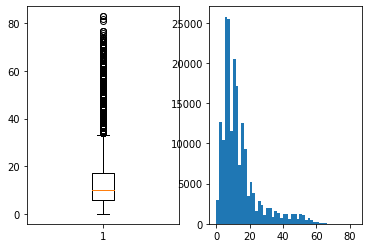

In [112]:
print('리뷰의 평균 길이: {}'.format(np.mean(num_sentence)))
print('리뷰의 최대길이: {}'.format(np.max(num_sentence)))
print('문장길이 표준편차 : {} '.format(np.std(num_sentence)))

plt.subplot(1,2,1)
plt.boxplot(num_sentence)
plt.subplot(1,2,2)
plt.hist(num_sentence, bins=50)
plt.show()

리뷰의 길이가 많이 길지 않고, 리뷰의 길이가 길수록 좋은 데이터라는 생각으로 모두 가져가기로 결정!

### 2) X_train, X_test Padding 시키기

---
나중에 RNN할것을 염두에 두고 패딩을 PRE에 줘본다.

word vector dim은 보통 300~400 사이즈를 준다고 하니, 300으로 설정한다.

In [118]:
#maxlen은 앞서구한 최대값 116으로 넣어준다.
maxlen = int(np.max(num_sentence))

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value = word_to_index['<PAD>'],
                                                        padding = 'pre',
                                                        maxlen = maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value = word_to_index['<PAD>'],
                                                       padding = 'pre',
                                                       maxlen = maxlen)

print('패딩 적용한 shape : X_train{}, X_test{}'.format(X_train.shape, X_test.shape))

패딩 적용한 shape : X_train(146182, 83), X_test(49157, 83)


In [119]:
print('shape : X_train{}, X_test{}'.format(X_train.shape, X_test.shape))
print('shape : y_train{}, y_test{}'.format(y_train.shape, y_test.shape))

shape : X_train(146182, 83), X_test(49157, 83)
shape : y_train(146182,), y_test(49157,)


## STEP 4. 모델구성 및 validation set 구성

---
모델은 3가지 이상 다양하게 구성해보자

### 1) validation set 나누기

---
validation은 train의 20%로 설정

In [120]:
val_num = int(len(X_train) * 0.2)
X_val = X_train[:val_num]
part_X_train = X_train[val_num:]
y_val = y_train[:val_num]
part_y_train = y_train[val_num:]

print('총 데이터 갯수 : {}'.format(len(X_train)))
print('validation number : {}'.format(val_num))
print('나눠준 데이터 셋 모양 : x_train{}, x_val{}, y_train{}, y_val{}'.format(part_X_train.shape, X_val.shape, part_y_train.shape, y_val.shape))

총 데이터 갯수 : 146182
validation number : 29236
나눠준 데이터 셋 모양 : x_train(116946, 83), x_val(29236, 83), y_train(116946,), y_val(29236,)


###2) 모델 구성하기
---
 - vocab_size = 15000 
 -  word_vector_dim = 256
 -  모델 구성
    - (1-1) NLP쪽 모델만 사용한 LSTM 모델
    - (1-2) NLP쪽 모델만 사용한 GRU 모델
    - (2) 1D CNN을 이용한 모델
    - (3) 1D CNN + LSTM 결합 모델
- optimizer : adam (가장 보편적으로 사용되는 adam 사용)

#### (1-1) NLP쪽 모델만 사용한 LSTM 모델

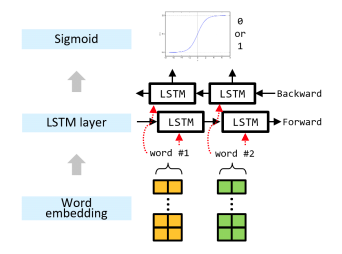

In [26]:
vocab_size = 15000
word_vector_dim = 256
hidden_units = 128

model_1 = tf.keras.Sequential()
#임베딩층
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
#LSTM층
model_1.add(tf.keras.layers.LSTM(hidden_units))
model_1.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_1.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


In [27]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         3840000   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,038,161
Trainable params: 4,038,161
Non-trainable params: 0
_________________________________________________________________


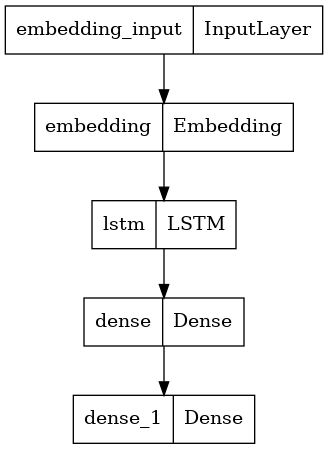

In [29]:
tf.keras.utils.plot_model(model_1)

LSTM층 1개, dense층 2개를 사용한 모델을 생성했다.  
이제 컴파일해서 돌려보자!

##STEP 4. 모델훈련 개시

In [30]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 20

model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_1 = model_1.fit(part_X_train,
                      part_y_train,
                      epochs = epochs,
                      callbacks = [es, mc],
                      batch_size = 512,
                      validation_data = (X_val, y_val))

Epoch 1/20
228/229 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8077
Epoch 1: val_accuracy improved from -inf to 0.84550, saving model to best_model.h5
229/229 [==============================] - 15s 29ms/step - loss: 0.4157 - accuracy: 0.8078 - val_loss: 0.3496 - val_accuracy: 0.8455
Epoch 2/20
227/229 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8645
Epoch 2: val_accuracy improved from 0.84550 to 0.84871, saving model to best_model.h5
229/229 [==============================] - 6s 26ms/step - loss: 0.3152 - accuracy: 0.8645 - val_loss: 0.3445 - val_accuracy: 0.8487
Epoch 3/20
228/229 [============================>.] - ETA: 0s - loss: 0.2730 - accuracy: 0.8841
Epoch 3: val_accuracy improved from 0.84871 to 0.85083, saving model to best_model.h5
229/229 [==============================] - 7s 29ms/step - loss: 0.2731 - accuracy: 0.8841 - val_loss: 0.3486 - val_accuracy: 0.8508
Epoch 4/20
227/229 [============================>.] - ETA: 0

In [31]:
loaded_model_1 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_1.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 7s 4ms/step - loss: 0.3511 - accuracy: 0.8497

 테스트 정확도: 0.8497


In [32]:
results = model_1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4309 - accuracy: 0.8399 - 5s/epoch - 4ms/step
[0.4309121370315552, 0.8398600220680237]


In [33]:
history_1_dict = history_1.history
print(history_1_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## STEP 6. Loss, Accuracy 그래프 시각화

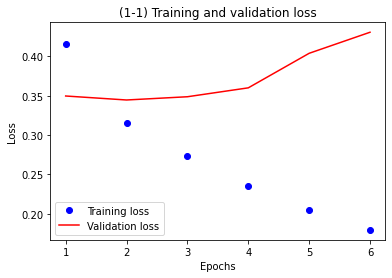

In [36]:
acc = history_1_dict['accuracy']
val_acc = history_1_dict['val_accuracy']
loss = history_1_dict['loss']
val_loss = history_1_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('(1-1) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

epochs 2회 이상부터 과적합이 되는 것을 알 수 있다. 

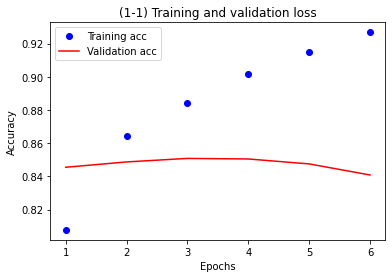

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('(1-1) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

정확도 또한 epochs를 지날수록 점점 감소하여 과적합이 되고 있음을 알 수 있다.

#### (1-2) NLP쪽 모델만 사용한 GRU 모델

In [38]:
vocab_size = 15000
word_vector_dim = 256
hidden_units = 128

model_2 = tf.keras.Sequential()
#임베딩층
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
#GRU층
model_2.add(tf.keras.layers.GRU(hidden_units))
model_2.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_2.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         3840000   
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,989,265
Trainable params: 3,989,265
Non-trainable params: 0
_________________________________________________________________


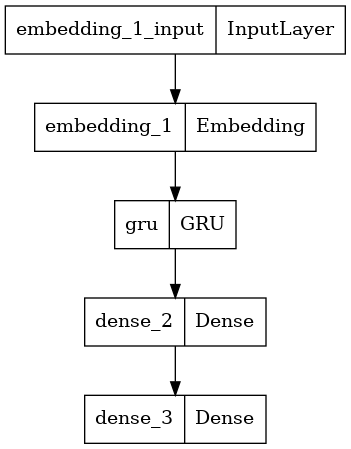

In [39]:
model_2.summary()
tf.keras.utils.plot_model(model_2)

In [59]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 20

model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_2 = model_2.fit(part_X_train,
                      part_y_train,
                      epochs = epochs,
                      callbacks = [es, mc],
                      batch_size = 512,
                      validation_data = (X_val, y_val))

Epoch 1/20
229/229 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9328
Epoch 1: val_accuracy improved from -inf to 0.84191, saving model to best_model.h5
229/229 [==============================] - 8s 23ms/step - loss: 0.1609 - accuracy: 0.9328 - val_loss: 0.4922 - val_accuracy: 0.8419
Epoch 2/20
229/229 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9421
Epoch 2: val_accuracy did not improve from 0.84191
229/229 [==============================] - 5s 21ms/step - loss: 0.1380 - accuracy: 0.9421 - val_loss: 0.5235 - val_accuracy: 0.8327
Epoch 3/20
229/229 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9487
Epoch 3: val_accuracy did not improve from 0.84191
229/229 [==============================] - 5s 21ms/step - loss: 0.1221 - accuracy: 0.9487 - val_loss: 0.6213 - val_accuracy: 0.8365
Epoch 4/20
229/229 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9544
Epoch 4: val_accuracy did not impro

In [65]:
loaded_model_2 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_2.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 7s 4ms/step - loss: 0.4864 - accuracy: 0.8404

 테스트 정확도: 0.8404


In [66]:
results = model_2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7279 - accuracy: 0.8349 - 5s/epoch - 4ms/step
[0.7279261946678162, 0.8348556756973267]


In [62]:
history_2_dict = history_2.history
print(history_2_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


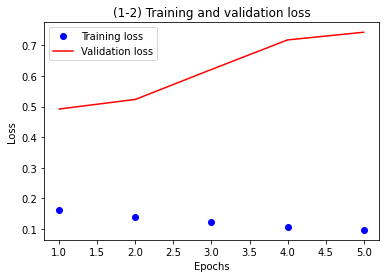

In [63]:
acc = history_2_dict['accuracy']
val_acc = history_2_dict['val_accuracy']
loss = history_2_dict['loss']
val_loss = history_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('(1-2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

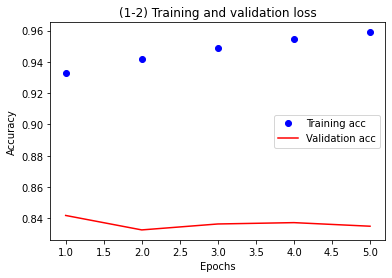

In [64]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('(1-2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

여기서도 2회가 지나면 로스는 증가하고 정확도가 감소하여 과적합이 진행되는 것을 알 수 있다. 

#### (2) 1D CNN을 이용한 모델
---
Conv1D, Maxpooling 1D, global Maxpooling 등을 사용하여 모델 세워보기

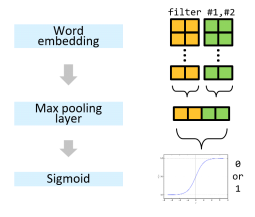

In [73]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수
vocab_size = 15000

model_3 = Sequential()
model_3.add(Embedding(vocab_size, embedding_dim))
model_3.add(Dropout(dropout_ratio))
model_3.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model_3.add(GlobalMaxPooling1D())
model_3.add(Dense(hidden_units, activation='relu'))
model_3.add(Dropout(dropout_ratio))
model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 256)         3840000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 256)         196864    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

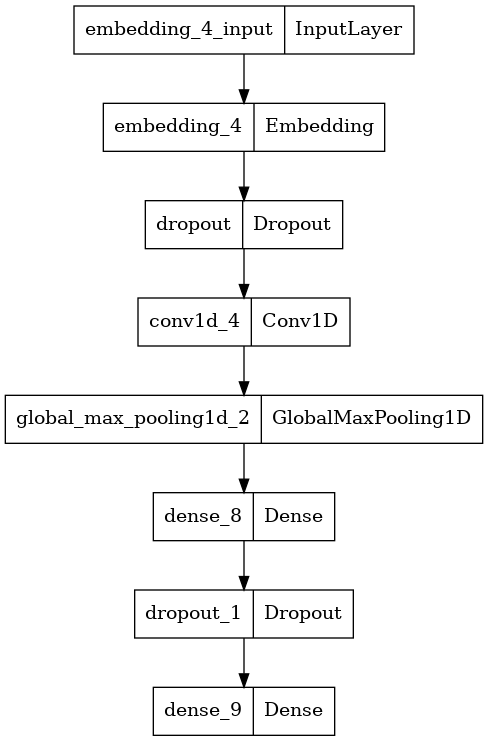

In [74]:
tf.keras.utils.plot_model(model_3)

조금 더 깊게 보기위해 Conv 1회 후max pooling으로 정리해준 후, Conv를 1회 더 진행하고 global max pooling으로 정리해 주었다.   
그리고 중간중간 DropOut을 넣어 과적합을 방지했다.  
과연 과적합에서 좀 더 자유로울 것인가...

In [79]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 20

model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_3 = model_3.fit(part_X_train,
                      part_y_train,
                      epochs = epochs,
                      callbacks = [es, mc],
                      batch_size = 512,
                      validation_data = (X_val, y_val))

Epoch 1/20
229/229 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.7982
Epoch 1: val_accuracy improved from -inf to 0.84786, saving model to best_model.h5
229/229 [==============================] - 7s 25ms/step - loss: 0.4258 - accuracy: 0.7982 - val_loss: 0.3418 - val_accuracy: 0.8479
Epoch 2/20
229/229 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8752
Epoch 2: val_accuracy improved from 0.84786 to 0.85740, saving model to best_model.h5
229/229 [==============================] - 6s 26ms/step - loss: 0.2998 - accuracy: 0.8752 - val_loss: 0.3294 - val_accuracy: 0.8574
Epoch 3/20
229/229 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9086
Epoch 3: val_accuracy did not improve from 0.85740
229/229 [==============================] - 5s 23ms/step - loss: 0.2333 - accuracy: 0.9086 - val_loss: 0.3394 - val_accuracy: 0.8562
Epoch 4/20
228/229 [============================>.] - ETA: 0s - loss: 0.1740 - accuracy: 0.9347


In [80]:
loaded_model_3 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_3.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3336 - accuracy: 0.8567

 테스트 정확도: 0.8567


In [81]:
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4928 - accuracy: 0.8468 - 3s/epoch - 2ms/step
[0.49279025197029114, 0.8467766642570496]


In [82]:
history_3_dict = history_3.history
print(history_3_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


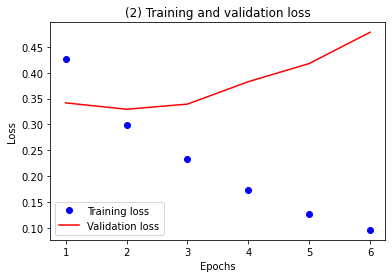

In [83]:
acc = history_3_dict['accuracy']
val_acc = history_3_dict['val_accuracy']
loss = history_3_dict['loss']
val_loss = history_3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

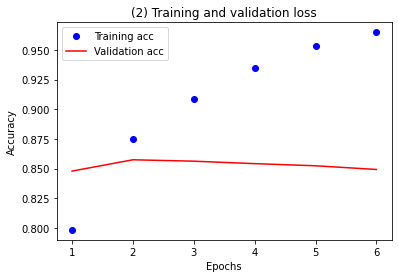

In [84]:
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

워낙 자료가 적기도해서 그런가... Dropout을 사용해도 epoch 2회 이상가면 과적합이 이뤄지는게 보인다...흑

### (3) 1D CNN + LSTM 결합 모델 

---

CNN-LSTM Model로 미세먼지 예측같은 시계열 예측, 쇼핑 아이템 추천 서비스, 에너지 수요예측 등 다양한 연구가 진행되고 있는 것을 확인했다.   
아무래도 앞요소들과의 관계를 고려하는 LSTM, RNN등이 사용되다보니 시계열 예측쪽에서 유의미한 연구가 많이 나오는 것 같다.   
CNN-LSTM 모델은 word embedding(vector)을 input으로 넣어 convolution layer와 max pooling layer를 통과해 local feature을 추출하고, LSTM 모델을 사용해 공간적인 feature을 연속적으로 통합하는 방식으로 일반적인 NN(Neural Network) 모델보다 훨씬 더 뛰어난 성능을 보인다.  

CNN 모델은 입력된 텍스트를 여러 영역으로 나누어 특정 지역의 정보를 추출할 수는 있지만 긴 문장에서는 단어 간의 의존성을 파악하지 못하는데, CNN 모델과 LSTM 모델을 결합해 문장 내의 지역 정보를 순차적으로 통합하면 이러한 한계를 해결할 수 있다고한다. 

[Naver O2 관련내용](https://d2.naver.com/helloworld/1264836?fbclid=IwAR1__yoPP5hCJsLaf9FDifFg4v55RTBDQPPHzsmsAxIczpci4zHsojVJ4e0)  

[논문-Dimensional Sentiment Analysis Using a Regional CNN-LSTM Model](https://aclanthology.org/P16-2037.pdf)

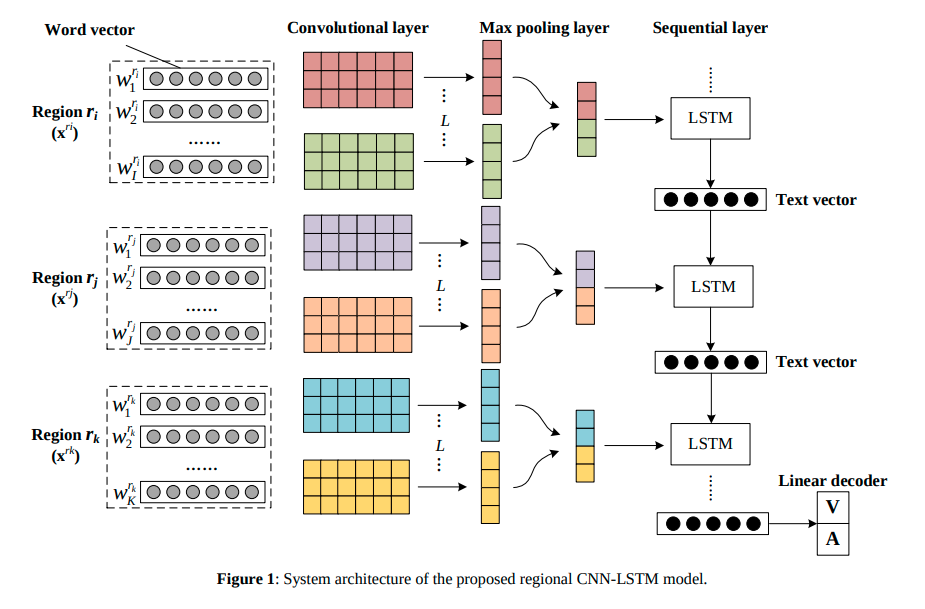

[CNN_LSTM 자료](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/time-series/Ch5-CNN-LSTM.ipynb#scrollTo=HJuGI3_sJ2xx)

[CNN-LSTM 리뷰감성분석](https://www.koreascience.or.kr/article/JAKO201909358629867.pdf)

[wiki docs - CNN으로 리뷰 분류](https://wikidocs.net/80783)  
상기 자료들을 참고하여 모델을 제작함

In [90]:
vocab_size = 15000
word_vector_dim = 256
hidden_units = 128 # 뉴런의 수
dropout_ratio = 0.25 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기

model_4 = tf.keras.Sequential()
#임베딩층
model_4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
#CNN층
model_4.add(tf.keras.layers.Conv1D(num_filters, kernel_size, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(tf.keras.layers.MaxPooling1D())
#25% Drop out 삽입하여 LSTM 반복학습을 유지할 수 있도록 함
model_4.add(Dropout(0.25))
#LSTM층
model_4.add(tf.keras.layers.LSTM(hidden_units))
#25% Drop out 삽입하여 LSTM 반복학습을 유지할 수 있도록 함
model_4.add(Dropout(0.25))
model_4.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_4.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 256)         3840000   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 256)         196864    
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                      

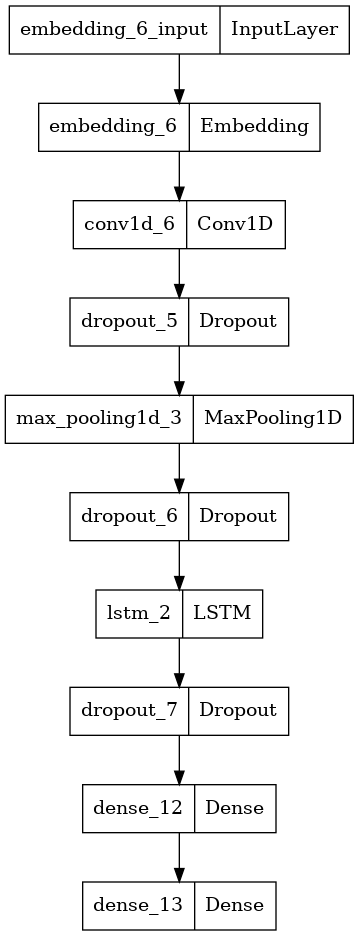

In [91]:
tf.keras.utils.plot_model(model_4)

"Conv 1회 - Maxpooling - Dropout"까지의 CNN 구조와  
"LSTM - Dropout - Dense" 로 이어지는   
**CNN - LSTM의 구조를 완성**하였다.   

과연 이 모델은 어떻게 결과를 내줄지 너무 궁금하다:)!!

In [92]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 20

model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_4 = model_4.fit(part_X_train,
                      part_y_train,
                      epochs = epochs,
                      callbacks = [es, mc],
                      batch_size = 512,
                      validation_data = (X_val, y_val))

Epoch 1/20
227/229 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.7876
Epoch 1: val_accuracy improved from -inf to 0.83209, saving model to best_model.h5
229/229 [==============================] - 11s 36ms/step - loss: 0.4346 - accuracy: 0.7879 - val_loss: 0.3651 - val_accuracy: 0.8321
Epoch 2/20
227/229 [============================>.] - ETA: 0s - loss: 0.3225 - accuracy: 0.8585
Epoch 2: val_accuracy improved from 0.83209 to 0.84071, saving model to best_model.h5
229/229 [==============================] - 8s 34ms/step - loss: 0.3227 - accuracy: 0.8583 - val_loss: 0.3563 - val_accuracy: 0.8407
Epoch 3/20
227/229 [============================>.] - ETA: 0s - loss: 0.2739 - accuracy: 0.8828
Epoch 3: val_accuracy did not improve from 0.84071
229/229 [==============================] - 7s 33ms/step - loss: 0.2739 - accuracy: 0.8827 - val_loss: 0.3749 - val_accuracy: 0.8366
Epoch 4/20
227/229 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9050

In [93]:
loaded_model_4 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_4.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 7s 4ms/step - loss: 0.3614 - accuracy: 0.8352

 테스트 정확도: 0.8352


In [94]:
results = model_4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.4757 - accuracy: 0.8267 - 6s/epoch - 4ms/step
[0.47568219900131226, 0.8266574740409851]


In [95]:
history_4_dict = history_4.history
print(history_4_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


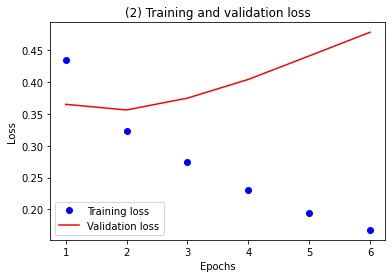

In [96]:
acc = history_4_dict['accuracy']
val_acc = history_4_dict['val_accuracy']
loss = history_4_dict['loss']
val_loss = history_4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

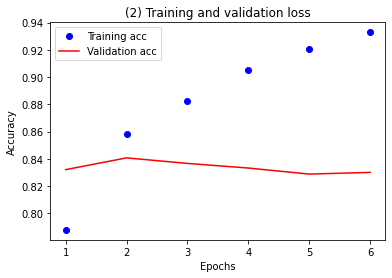

In [97]:
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

두둥탁!!!!!!!!!!!!!!!!!!!  

논문에는 **CNN-LSTM 모델의 성능이 단일 모델보다 좋다**고 했는데 반대로 나와버렸다...?

아.... 이렇게 섞었는데도 2회를 넘지못하다니...?  
진짜 모델이 너무 어려워서 과적합이 일어난걸까??  
워드 벡터를 좀 줄이면 모델이 가벼워질까...?  
이거롤 한번만 다시 시도해보고 넘어가자......후.....

### (3-1) 1D CNN + LSTM 결합 모델 - word vector dim, 모델 복잡도 낮춤

---

- word vector dim값 : 256 -> 64  
- num_filters 값 : 256 -> 128  
확실한 차이를 확인하기위해 복합적으로 확 낮춰주었다.  

In [121]:
vocab_size = 10000
word_vector_dim = 64
hidden_units = 128 # 뉴런의 수
dropout_ratio = 0.25 # 드롭아웃 비율
num_filters = 128 # 커널의 수
kernel_size = 3 # 커널의 크기

model_5 = tf.keras.Sequential()
#임베딩층
model_5.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
#CNN층
model_5.add(tf.keras.layers.Conv1D(num_filters, kernel_size, activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(tf.keras.layers.MaxPooling1D())
#25% Drop out 삽입하여 LSTM 반복학습을 유지할 수 있도록 함
model_5.add(Dropout(0.25))
#LSTM층
model_5.add(tf.keras.layers.LSTM(hidden_units))
#25% Drop out 삽입하여 LSTM 반복학습을 유지할 수 있도록 함
model_5.add(Dropout(0.25))
model_5.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_5.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         24704     
                                                                 
 dropout_14 (Dropout)        (None, None, 128)         0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                      

In [122]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 20

model_5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history_5 = model_5.fit(part_X_train,
                      part_y_train,
                      epochs = epochs,
                      callbacks = [es, mc],
                      batch_size = 512,
                      validation_data = (X_val, y_val))

Epoch 1/20
229/229 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.7787
Epoch 1: val_accuracy improved from -inf to 0.83048, saving model to best_model.h5
229/229 [==============================] - 7s 22ms/step - loss: 0.4508 - accuracy: 0.7787 - val_loss: 0.3706 - val_accuracy: 0.8305
Epoch 2/20
227/229 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8475
Epoch 2: val_accuracy improved from 0.83048 to 0.83667, saving model to best_model.h5
229/229 [==============================] - 4s 18ms/step - loss: 0.3437 - accuracy: 0.8475 - val_loss: 0.3617 - val_accuracy: 0.8367
Epoch 3/20
228/229 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.8640
Epoch 3: val_accuracy did not improve from 0.83667
229/229 [==============================] - 4s 18ms/step - loss: 0.3103 - accuracy: 0.8641 - val_loss: 0.3610 - val_accuracy: 0.8361
Epoch 4/20
228/229 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8790


In [123]:
loaded_model_5 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_5.evaluate(X_test, y_test)[1]))

results = model_5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 [==============================] - 7s 4ms/step - loss: 0.3757 - accuracy: 0.8329

 테스트 정확도: 0.8329
1537/1537 - 5s - loss: 0.4471 - accuracy: 0.8283 - 5s/epoch - 3ms/step
[0.4471154510974884, 0.8283052444458008]


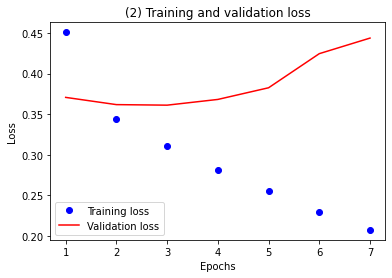

In [124]:
history_5_dict = history_5.history

acc = history_5_dict['accuracy']
val_acc = history_5_dict['val_accuracy']
loss = history_5_dict['loss']
val_loss = history_5_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

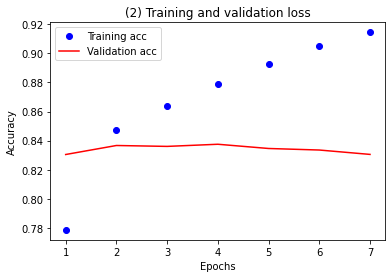

In [125]:
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('(2) Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

그래프가 살짝 완만해지긴 했으나 결과적으로는 동일한 모습이다.....흠...........흑......

## STEP 7. 학습된 Embedding 레이어 분석
---
**(1-1) NLP쪽 모델만 사용한 LSTM 모델**  
 - loss: 0.4309 - accuracy: 0.8399 
 - 테스트 정확도: 0.8497 로 생각보다 약한 결과가 나왔다. 
 - 또한 epochs 2회만에 val_loss가 증가하며 과적합된 모습을 볼 수 있었다.(이걸 어떻게 해결해야하는지 모르겠음... 드롭아웃하면 핵심단어가 빠질 수도 있어서 안될것 같기도 한데..)

**(1-2) NLP쪽 모델만 사용한 GRU 모델**
 - loss: 0.4467 - accuracy: 0.8404
 - 테스트 정확도: 0.849
 - **모델의 복잡도가 높으면 학습에서 본 데이터를 너무 따라가는 경향이 있다**고 하는데, 이 경우에도 2회 이상이되면 과적합되는 것을보아 각각의 모델들이 너무 복잡해서? 바로 과적합이 되는 것 같다.
 - LSTM이나 GRU나 방식이 유사해서 그런지 결과값에서 크게 다른점은 보이지 않고 유사하다. 

**(2) 1D CNN 등을 이용한 모델**
 - loss: 0.4928 - accuracy: 0.8468
 - 테스트 정확도: 0.8567
 - 앞서 진행한 두개와 비교해보면, (1-1)보단 못하지만, (1-2)보다는 loss율도 낮고 정확도가 높아 이 경우엔 1D CNN을 이용한 모델도 좋은 결과를 이끌어 냄을 확인했다. 
 - 그럼 두개를 섞은 모델에서는 더 좋은 결과를 나타낼지 궁금하다^0^!

**(3) 1D CNN + LSTM 결합 모델**
 - loss: 0.4757 - accuracy: 0.8267
 - 테스트 정확도: 0.8352
 - 상기 3가지의 경우보다도 정확도가 떨어지는 것이 보인다. 또한 다른 모델과 동일하게 epoch가 2회이상 진행되면 과적합이 이뤄지는 것으로 보아,,, 모델의 복잡도가 문제인 것 같아 동일한 모델에서 word vector dim을 확 낮춰 다시 진행해보기로 하였다.   


**(3-1) 1D CNN + LSTM 결합 모델 - word vector dim 낮춤**
 - loss: 0.4358 - accuracy: 0.8261 
 - 테스트 정확도: 0.8329
 - 워드 벡터를 낮춰 더 확실하게 넣어줬음에도 3번과 비슷한 결과를 보여줬다...  
 - 
